In [145]:
import os, sys
import iris
import iris.plot as iplt
import numpy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
import general_io as gio
import convenient_universal as uconv

In [118]:
% matplotlib inline

In [119]:
def convert_to_joules(cube):
    """Convert units to Joules"""
    
    assert 'W' in str(cube.units)
    assert 'days' in str(cube.coord('time').units)
    
    time_span_days = cube.coord('time').bounds[:, 1] - cube.coord('time').bounds[:, 0]
    time_span_seconds = time_span_days * 60 * 60 * 24
    
    cube.data = cube.data * uconv.broadcast_array(time_span_seconds, 0, cube.shape)
    cube.units = str(cube.units).replace('W', 'J')
    
    return cube

In [151]:
def calc_change(ohc_cube, cubic=False):
    """Calculate change between first and last timestep."""
        
    ohc_change = ohc_cube.data[-1] - ohc_cube.data[0]
    
    if cubic:
        print('OHC change (cubic):', ohc_change)
    else:
        print('OHC change:', ohc_change)

    
def calc_accumulated_anomaly(hfds_cube, cubic=False):
    """Calculate the accumulated anomaly."""
    
    assert str(hfds_cube.units) == 'J'
    
    hfds_anomaly = hfds_cube.data - hfds_cube.data[0]
    
    if cubic:
        print('Accumulated hfds anomaly (cubic):', hfds_anomaly.sum())
    else:
        print('Accumulated hfds anomaly:', hfds_anomaly.sum())

In [146]:
def cubic_polynomial(cube):
    """Fit a cubic polyniomial"""
    
    time_points = cube.coord('time').points
    
    ca, cb, cc, cd = numpy.polynomial.polynomial.polyfit(time_points, cube.data, 3)
    polynomial = ca + cb * time_points + cc * time_points**2 + cd * time_points**3
    
    cubic_cube = iris.cube.Cube(polynomial,
                                standard_name=cube.standard_name,
                                long_name=cube.long_name,
                                var_name=cube.var_name,
                                units=cube.units,
                                attributes=cube.attributes,
                                dim_coords_and_dims=[(cube.coord('time'), 0)],
                                )
    
    return cubic_cube

In [161]:
def print_results(model, experiment, mip, inferred=False, window=1, plot=False):
    """Get the data files"""

    time_constraint = gio.get_time_constraint(['1861-01-01', '2005-12-31'])
    insert = '-inferred-' if inferred else '-'
        
    ohc_globe_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/ohc/latest/dedrifted/ohc-globe-sum_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, model, experiment, mip)
    hfds_file = '/g/data/r87/dbi599/DRSv2/CMIP5/%s/%s/yr/ocean/%s/hfds/latest/hfds%ssum-hemispheric-metrics_Oyr_%s_%s_%s_all.nc' %(model, experiment, mip, insert, model, experiment, mip)
    
    ohc_globe_cube = iris.load_cube(ohc_globe_file, 'ocean heat content globe sum' & time_constraint)
    hfds_globe_cube_W = iris.load_cube(hfds_file, 'Downward Heat Flux at Sea Water Surface globe sum' & time_constraint)
    
    hfds_globe_cube_J = convert_to_joules(hfds_globe_cube_W)
    
    if window > 1:
        ohc_globe_cube = ohc_globe_cube.rolling_window('time', iris.analysis.MEAN, window)
        hfds_globe_cube_J = hfds_globe_cube_J.rolling_window('time', iris.analysis.MEAN, window)
    
    ohc_cubic = cubic_polynomial(ohc_globe_cube)
    hfds_cubic = cubic_polynomial(hfds_globe_cube_J)
    
    if plot:
        iplt.plot(ohc_globe_cube)
        #iplt.plot(ohc_cubic)
        plt.title('ohc global sum')
        plt.show()
        
        iplt.plot(hfds_globe_cube_J)
        #iplt.plot(hfds_cubic)
        plt.title('hfds global sum')
        plt.show()
    
    calc_change(ohc_globe_cube)
    calc_accumulated_anomaly(hfds_globe_cube_J)
    
    #calc_change(ohc_cubic, cubic=True)
    #calc_accumulated_anomaly(hfds_cubic, cubic=True)

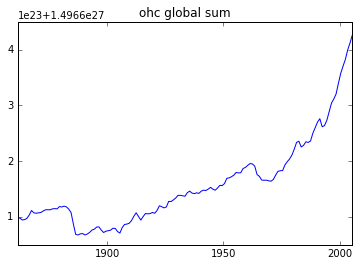

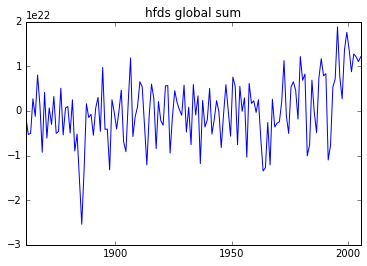

OHC change: 3.28155447301e+23
Accumulated hfds anomaly: 2.392877613e+23


In [162]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, plot=True)

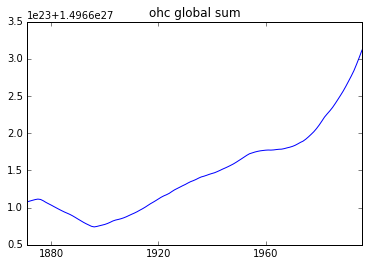

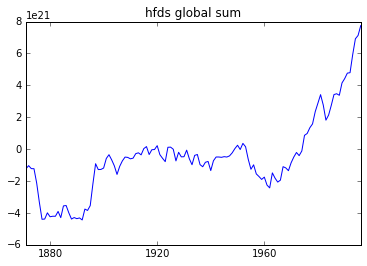

OHC change: 2.03924261912e+23
Accumulated hfds anomaly: 8.95008227248e+22


In [163]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, window=20, plot=True)

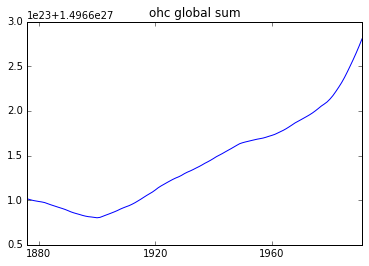

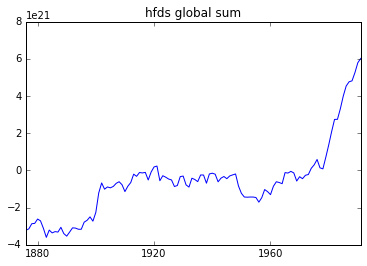

OHC change: 1.7913666101e+23
Accumulated hfds anomaly: 3.01865011866e+23


In [164]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, window=30, plot=True)

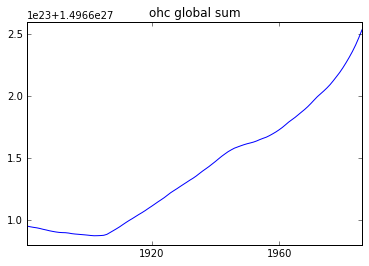

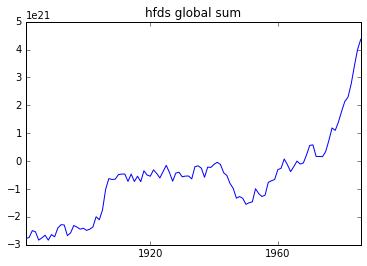

OHC change: 1.58296669827e+23
Accumulated hfds anomaly: 2.23434957325e+23


In [165]:
print_results('CanESM2', 'historical', 'r1i1p1', inferred=True, window=40, plot=True)

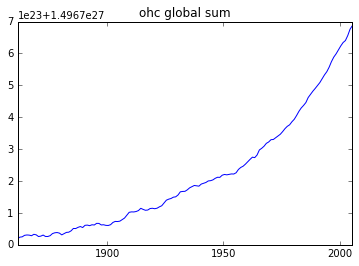

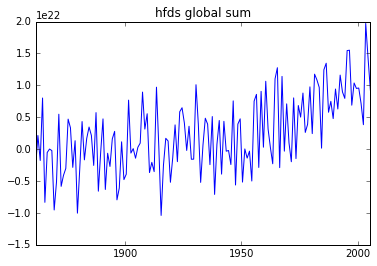

OHC change: 6.68632731466e+23
Accumulated hfds anomaly: 7.78630222378e+23


In [166]:
print_results('CanESM2', 'historicalGHG', 'r1i1p1', inferred=True, plot=True)

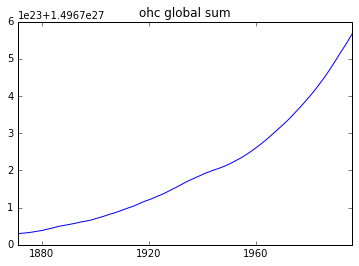

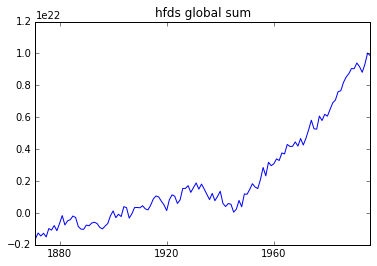

OHC change: 5.38189048564e+23
Accumulated hfds anomaly: 4.71397980742e+23


In [167]:
print_results('CanESM2', 'historicalGHG', 'r1i1p1', inferred=True, window=20, plot=True)

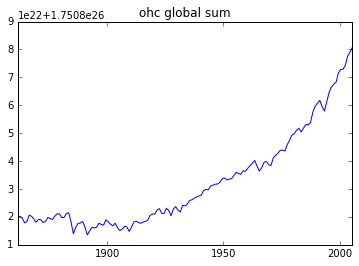

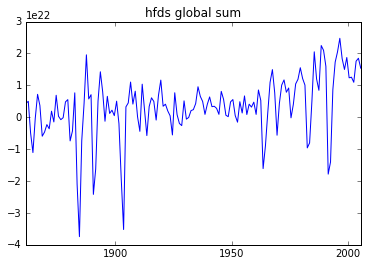

OHC change: 6.06995359294e+22
Accumulated hfds anomaly: -1.42369620337e+23


In [168]:
print_results('CCSM4', 'historical', 'r1i1p1', plot=True)

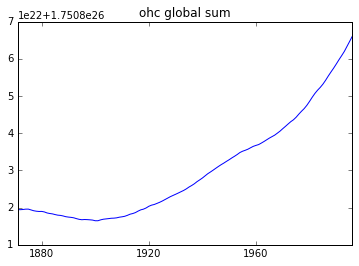

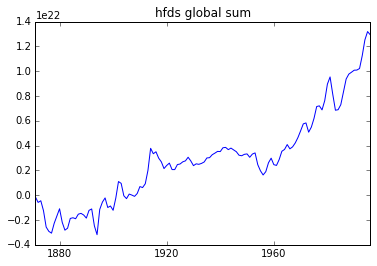

OHC change: 4.66401357994e+22
Accumulated hfds anomaly: 3.7410628748e+23


In [169]:
print_results('CCSM4', 'historical', 'r1i1p1', window=20, plot=True)

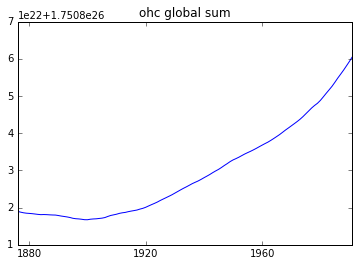

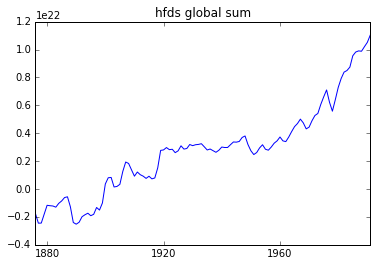

OHC change: 4.15401522595e+22
Accumulated hfds anomaly: 5.18790894109e+23


In [170]:
print_results('CCSM4', 'historical', 'r1i1p1', window=30, plot=True)

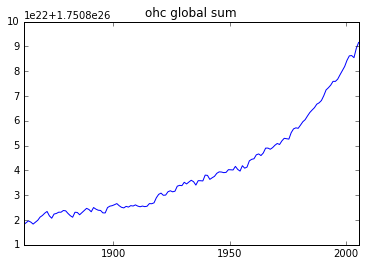

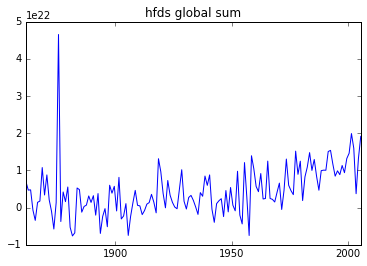

OHC change: 7.34620247965e+22
Accumulated hfds anomaly: -3.72792208472e+23


In [171]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', plot=True)

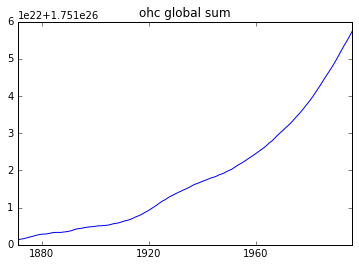

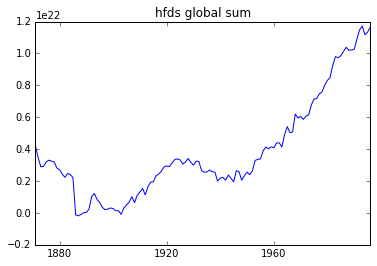

OHC change: 5.61874765359e+22
Accumulated hfds anomaly: -4.82772003169e+22


In [172]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', window=20, plot=True)

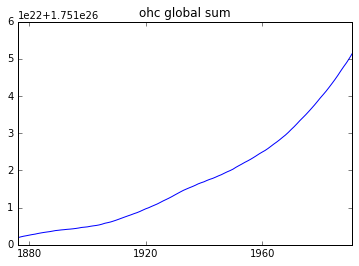

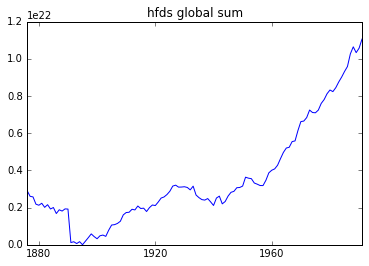

OHC change: 4.95870267198e+22
Accumulated hfds anomaly: 7.67519155332e+22


In [173]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', window=30, plot=True)

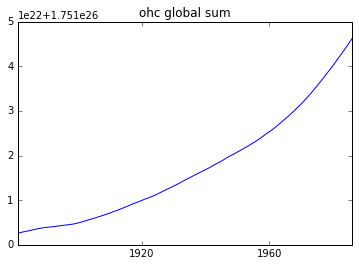

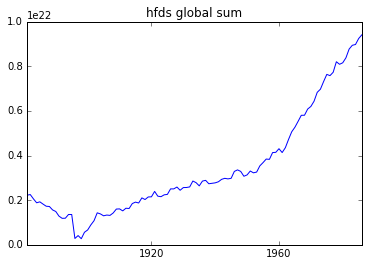

OHC change: 4.37634512987e+22
Accumulated hfds anomaly: 1.24806287161e+23


In [174]:
print_results('CCSM4', 'historicalGHG', 'r1i1p1', window=40, plot=True)